In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain_openai langsmith langgraph langchain numexpr langchainhub sqlalchemy langchain-communityc datetime matplotlib

In [2]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")
# # Optional, add tracing in LangSmith

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "XMODE-plot"

In [3]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/tools')
sys.path.append(os.path.dirname(os.getcwd()) + '/src')

In [4]:
from typing import Sequence

from langchain import hub
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from utils import _get_db_schema


from output_parser import LLMCompilerPlanParser, Task
from image_analysis_tool_m3ae_multiple import get_image_analysis_tools
from text2SQL import get_text2SQL_tools
from plotting_tool import get_plotting_tools

model="gpt-4o" #gpt-4-turbo-preview
db_path="/home/ubuntu/workspace/XMODE-LLMCompiler/mimic_iv_cxr_with_path.db"
temperature=0
## Tools
translate= get_text2SQL_tools(ChatOpenAI(model=model, temperature=temperature),db_path)
image_analysis = get_image_analysis_tools(db_path)
data_preparation= get_plotting_tools(ChatOpenAI(model=model, temperature= temperature))
tools = [translate,image_analysis,data_preparation]


prompt = ChatPromptTemplate.from_messages(
[
("system",'''Given a user question and a database schema, analyze the question to identify and break it down into relevant sub-questions. 
    Determine which tools (e.g., text2SQL, image_analysis, plotting) are appropriate for answering each sub-question based on the available database information and tools.
    First, you should begin by thoroughly analyzing the user's main question. It’s important to understand the key components and objectives within the query.
    Next, you must review the provided database schema. This involves examining the tables, fields, and relationships within the database to identify which parts of the schema are relevant to the user’s question, and creat a set of sub-questions.
    For each sub-question, provide all the required information that may required in other tasks. In order to find this information look at the user question and the database inforamtion. Ensure you include all necessary information, including columns used for filtering in the retrieve part of the database related task (i.e. Text2SQL), especially when the user question involves plotting or data exploration.
    In cases where the user’s question involves data that is not directly available in the database schema —such as when there is no corresponding table or column for the required information or chest x-ray analysis— you must consider the need for image analysis using the image_analysis tools. 
    For instance, if the question involves comparision of studies, images, chest x-rays  for specific abnormality, disease or finding in the paitent study and the relevant column (e.g., abnormality, findings, chest x-ray) is not found in the database schema, you must retrieve th`image_path` of the study for image analysis, 
    This ensures we can address parts of the question that rely on visual data. If the question includes the study ID, you can directly initiate the image analysis task using the mentioned id for a study.
    In case the question asked for plotting, you must include the data_plotting tools.
    With a clear understanding of the question and the database schema, you can now break down the main question into smaller, more manageable sub-questions. 
    These sub-questions should each target a specific aspect of the main question. 
    After identifying the sub-questions, you should determine the most appropriate tools to answer each one. Depending on the nature of the sub-questions, we might use a variety of tools.
    Each sub-question should be a textual question. Dont generate a code as a sub-question.
    Each image analysis task should consider only one study. Study id is different than image path. 
    Include the database schema in the context for text2SQL tasks.
    It is also important to note that in the database, the current time is set to 2105-12-31 23:59:00. This must be taken into account when performing any time-based data queries or analyses.
    In any database retreival task, retieve `subject_id` together with other columns that may requir for next tasks, especially when the user question involves plotting or data exploration.
    Create a plan to solve it with the utmost parallelizability. 
    Each plan should comprise an action from the following  {num_tools} types:
{tool_descriptions}
{num_tools}. 
join(): Collects and combines results from prior actions.

- An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
- join should always be the last action in the plan, and will be called in two scenarios:
(a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
(b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
- Each action described above contains input/output types and description.
- You must strictly adhere to the input and output types for each action.
- The action descriptions contain the guidelines. You MUST strictly follow those guidelines when you use the actions.
- Each action in the plan should strictly be one of the above types. Follow the Python conventions for each action.
- Each action MUST have a unique ID, which is strictly increasing.
- Inputs for actions can either be constants or outputs from preceding actions. In the latter case, use the format $id to denote the ID of the previous action whose output will be the input.
- If there is an input from from preceding actions, always point its id as `$id` in the context of the action/
- Always call join as the last action in the plan. Say '<END_OF_PLAN>' after you call join
- Ensure the plan maximizes parallelizability.
- Only use the provided action types. If a query cannot be addressed using these, invoke the join action for the next steps.
- Never introduce new actions other than the ones provided.'''),
    ("user", '{messages}'),
    ("assistant", 'Remember, ONLY respond with the task list in the correct format! E.g.:\nidx. tool(arg_name=args)'),

]
)

/home/ubuntu/.pyenv/versions/xmode/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: LangChain has introduced a method called `with_structured_output` that is available on ChatModels capable of tool calling. You can read more about the method here: <https://python.langchain.com/docs/modules/model_io/chat/structured_output/>.Please follow our extraction use case documentation for more guidelines on how to do information extraction with LLMs. <https://python.langchain.com/docs/use_cases/extraction/>. If you notice other issues, please provide feedback here: <https://github.com/langchain-ai/langchain/discussions/18154>
  warn_deprecated(


In [5]:
def create_planner(
    llm: BaseChatModel, tools: Sequence[BaseTool], base_prompt: ChatPromptTemplate, database_schema:str=None
):
    tool_descriptions = "\n".join(
        f"{i+1}. {tool.description}\n"
        for i, tool in enumerate(
            tools
        )  # +1 to offset the 0 starting index, we want it count normally from 1.
    )
    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools)
        + 1,  # Add one because we're adding the join() tool at the end.
        tool_descriptions = tool_descriptions,
        #database_schema=database_schema,
    )
    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - you always need to have one image analysis if the text2SQL provides result.\n"
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools) + 1,
        tool_descriptions=tool_descriptions,
        #database_schema=database_schema,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        # print("wrap_messages state:", state)
        return {"messages": state}

    def wrap_and_get_last_index(state: list):
        next_task = 0
        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs["idx"] + 1
                break
        state[-1].content = state[-1].content + f" - Begin counting at : {next_task}"
        return {"messages": state}

    return (
                RunnableBranch(
                    (should_replan, wrap_and_get_last_index | replanner_prompt),
                    wrap_messages | planner_prompt,
                )
                | llm
                | LLMCompilerPlanParser(tools=tools)
            )


In [6]:
llm = ChatOpenAI(model=model, temperature=temperature)
planner = create_planner(llm, tools, prompt)


In [7]:
db_path="/home/ubuntu/workspace/XMODE-LLMCompiler/mimic_iv_cxr_with_path.db"
# "enumerate all detected abnormalities, given the study 57883509."
example_question="Plot number of male patient in each week that has chex-xray in last month and their chest-xray showed abnormality."
tables=['TB_CXR','PATIENTS']
# id= 2000
database_schema =_get_db_schema(db_path, tables)
inputs = {"question": example_question, "database_schema":database_schema}
# config = {"configurable": {"thread_id": "xmode-2000"}}
inputs=[HumanMessage(content=[inputs])]


In [7]:
for task in planner.stream(inputs):
    print(task["tool"], task["args"])
    print("---")

name='text2SQL' description='text2SQL(problem: str, context:str)-->str\nThe input for this tools should be `problem` as a textual question and `context` as a database_schema.\nThis tools is able to translate the question to the SQL code considering the database information.\nThe SQL code can be executed using sqlite3 library.\nUse the output of running the generated SQL code to answer the question.' args_schema=<class 'pydantic.v1.main.text2SQLSchema'> func=<function get_text2SQL_tools.<locals>.text2SQL at 0x7f36331a0dc0> {'problem': 'Retrieve the subject_id, study_id, and image_path for male patients who had a chest x-ray in the last month and their chest x-ray showed abnormality.', 'context': 'CREATE TABLE "PATIENTS" (\n\trow_id INTEGER, \n\tsubject_id INTEGER, \n\tgender TEXT, \n\tdob TEXT, \n\tdod TEXT\n)\n\n\nCREATE TABLE "TB_CXR" (\n\trow_id INTEGER, \n\tsubject_id INTEGER, \n\thadm_id REAL, \n\tstudy_id INTEGER, \n\timage_id TEXT, \n\tviewposition TEXT, \n\tstudydatetime TEXT, \

## Task Fetching Unit

In [8]:
import re
import time
from concurrent.futures import ThreadPoolExecutor, wait
from typing import Any, Dict, Iterable, List, Union

from langchain_core.runnables import (
    chain as as_runnable,
)
from typing_extensions import TypedDict


def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs["idx"])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task["tool"]
    if isinstance(tool_to_use, str):
        return tool_to_use
    args = task["args"]
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            # This will likely fail
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )
    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )


def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    # $1 or ${1} -> 1
    ID_PATTERN = r"\$\{?(\d+)\}?"

    def replace_match(match):
        # If the string is ${123}, match.group(0) is ${123}, and match.group(1) is 123.

        # Return the match group, in this case the index, from the string. This is the index
        # number we get back.
        idx = int(match.group(1))
        return str(observations.get(idx, match.group(0)))

    # For dependencies on other tasks
    if isinstance(arg, str):
        return re.sub(ID_PATTERN, replace_match, arg)
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback

        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    args_for_tasks = {}
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            args_for_tasks[task["idx"]] = task["args"]
            if (
                # Depends on other tasks
                deps
                and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], args_for_tasks[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(
            name=name, content=str(obs), additional_kwargs={"idx": k, "args": task_args}
        )
        for k, (name, task_args, obs) in new_observations.items()
    ]
    return tool_messages

In [9]:
import itertools


@as_runnable
def plan_and_schedule(messages: List[BaseMessage], config):
    tasks = planner.stream(messages, config)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        },
        config,
    )
    return scheduled_tasks

### Example Plan

In [11]:
tool_messages = plan_and_schedule.invoke(inputs)
tool_messages

context-first: {'status': 'success', 'data': [{'subject_id': 10501557, 'study_id': 50494231, 'image_id': 'dc8e362f-c7eed9e4-23b6a482-f5914468-cfee1143'}, {'subject_id': 10501557, 'study_id': 52176984, 'image_id': 'b011d8cc-dc7132b2-88dbf1ce-25edfe98-e7f91d64'}, {'subject_id': 10737408, 'study_id': 52883453, 'image_id': 'b67361c3-3f5ae62e-460f6431-325adf4d-0d2b1e14'}, {'subject_id': 10737408, 'study_id': 57292936, 'image_id': '42129ce4-60759151-2961e757-ed99e1bc-5fbd5220'}, {'subject_id': 11053589, 'study_id': 56374336, 'image_id': '3ff536d0-58474ed7-f99f6fc1-54ca116d-4838ad24'}, {'subject_id': 12215941, 'study_id': 50754556, 'image_id': '3c2dc8ec-12dcbe00-cb056bd4-ea8a493b-c53906b9'}, {'subject_id': 12215941, 'study_id': 52085431, 'image_id': '1212710f-946955fb-af038081-0e3072dd-4cd7f187'}, {'subject_id': 12215941, 'study_id': 53288444, 'image_id': '320613f2-ebd6f20f-3a56947b-9708596e-d18cbc9c'}, {'subject_id': 12215941, 'study_id': 53532266, 'image_id': '2aee3eca-ddf6adea-80e26b80-ff1

[FunctionMessage(content="{'status': 'success', 'data': [{'subject_id': 10501557, 'study_id': 50494231, 'image_id': 'dc8e362f-c7eed9e4-23b6a482-f5914468-cfee1143'}, {'subject_id': 10501557, 'study_id': 52176984, 'image_id': 'b011d8cc-dc7132b2-88dbf1ce-25edfe98-e7f91d64'}, {'subject_id': 10737408, 'study_id': 52883453, 'image_id': 'b67361c3-3f5ae62e-460f6431-325adf4d-0d2b1e14'}, {'subject_id': 10737408, 'study_id': 57292936, 'image_id': '42129ce4-60759151-2961e757-ed99e1bc-5fbd5220'}, {'subject_id': 11053589, 'study_id': 56374336, 'image_id': '3ff536d0-58474ed7-f99f6fc1-54ca116d-4838ad24'}, {'subject_id': 12215941, 'study_id': 50754556, 'image_id': '3c2dc8ec-12dcbe00-cb056bd4-ea8a493b-c53906b9'}, {'subject_id': 12215941, 'study_id': 52085431, 'image_id': '1212710f-946955fb-af038081-0e3072dd-4cd7f187'}, {'subject_id': 12215941, 'study_id': 53288444, 'image_id': '320613f2-ebd6f20f-3a56947b-9708596e-d18cbc9c'}, {'subject_id': 12215941, 'study_id': 53532266, 'image_id': '2aee3eca-ddf6adea-8

## Joiner

In [10]:
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Sequence
from typing import Any, Callable, Dict, Literal, Optional, Sequence, Type, Union, List

from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)


from concurrent.futures import ThreadPoolExecutor, wait
from typing import Any, Dict, Iterable, List, Union

from langchain_core.runnables import (
    chain as as_runnable,
)


class FinalResponse(BaseModel):
    """The final response/answer."""

    response: Union[str,Dict]


class Replan(BaseModel):
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response."""

    thought: str = Field(
        description="The chain of thought reasoning for the selected action"
    )
    action: Union[FinalResponse, Replan]
    
joiner_prompt=ChatPromptTemplate.from_messages(
        [("system",'''Solve a question answering task. Here are some guidelines:
    - In the Assistant Scratchpad, you will be given results of a plan you have executed to answer the user's question.
    - Thought needs to reason about the question based on the Observations in 1-2 sentences.
    - Ignore irrelevant action results.
    - If the required information is present, give a concise but complete and helpful answer to the user's question.
    - If you are unable to give a satisfactory finishing answer, replan to get the required information. Respond in the following format:
    - The current time is 2105-12-31 23:59:00 in case you need.
    Thought: <reason about the task results and whether you have sufficient information to answer the question>
    Action: <action to take>
    - If an error occurs during previous actions, replan and take corrective measures to obtain the required information.
    - Ensure that you consider errors in all the previous steps, and tries to replan accordingly.
    - The current time is 2105-12-31 23:59:00 in case it is need.
    - Ensure the final answer is provided in a structured format as JSON as follows:
        {{'Summary': <concise summary of the answer>,
         'details': <detailed explanation and supporting information>,
         'source': <source of the information or how it was obtained>,
         'inference':<your final inference as YES, No, or list of requested information without any extra information which you can take from the `labels` as given below>,
         'extra explanation':<put here the extra information that you dont provide in inference >,
         }}
         In the `inferencer` do not provide additinal explanation or description. Put them in `extra explanation`.

       
    Available actions:
    (1) Finish(the final answer to return to the user): returns the answer and finishes the task.
    (2) Replan(the reasoning and other information that will help you plan again. Can be a line of any length): instructs why we must replan
    ''' ),
        ("user", '{messages}'),
        ("assistant", '''
        Using the above previous actions, decide whether to replan or finish. 
        If all the required information is present, you may finish. 
        If you have made many attempts to find the information without success, admit so and respond with whatever information you have gathered so the user can work well with you. 
        '''),
        ]
    ).partial(
        examples=""
    )  
runnable = create_structured_output_runnable(JoinOutputs, llm, joiner_prompt)


In [11]:
def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return response + [
            SystemMessage(
                content=f"Context from last attempt: {decision.action.feedback}"
            )
        ]
    else:
        return response + [AIMessage(content=str(decision.action.response))]


def select_recent_messages(messages: list) -> dict:
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break
    return {"messages": selected[::-1]}


joiner = select_recent_messages | runnable | _parse_joiner_output

#input_messages = inputs + tool_messages


In [ ]:
tool_messages = plan_and_schedule.invoke(inputs)

input_messages = inputs + tool_messages

joiner.invoke(input_messages)


## Compse uning LangGraph

In [12]:
from typing import Dict

from langgraph.graph import END, MessageGraph, START

graph_builder = MessageGraph()

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state: List[BaseMessage]):
    if isinstance(state[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
        "join",
        # Next, we pass in the function that will determine which node is called next.
        should_continue,
        #{"plan_and_schedule": "plan_and_schedule", "__end__": "__end__"},
    )
graph_builder.add_edge(START, "plan_and_schedule")
chain = graph_builder.compile()

context-first: {'status': 'success', 'data': [{'subject_id': 10501557, 'study_id': 50494231, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10501557/s50494231/dc8e362f-c7eed9e4-23b6a482-f5914468-cfee1143.jpg'}, {'subject_id': 10501557, 'study_id': 52176984, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10501557/s52176984/b011d8cc-dc7132b2-88dbf1ce-25edfe98-e7f91d64.jpg'}, {'subject_id': 10737408, 'study_id': 52883453, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10737408/s52883453/b67361c3-3f5ae62e-460f6431-325adf4d-0d2b1e14.jpg'}, {'subject_id': 10737408, 'study_id': 57292936, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10737408/s57292936/42129ce4-60759151-2961e757-ed99e1bc-5fbd5220.jpg'}, {'subject_id': 11053589, 'study_id': 56374336, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p11/p11053589/s56374336/3ff536d0-58474ed7-f99f6fc1-54ca116d-4838ad24.jpg'}, {'subject_id': 12215941, 'stu

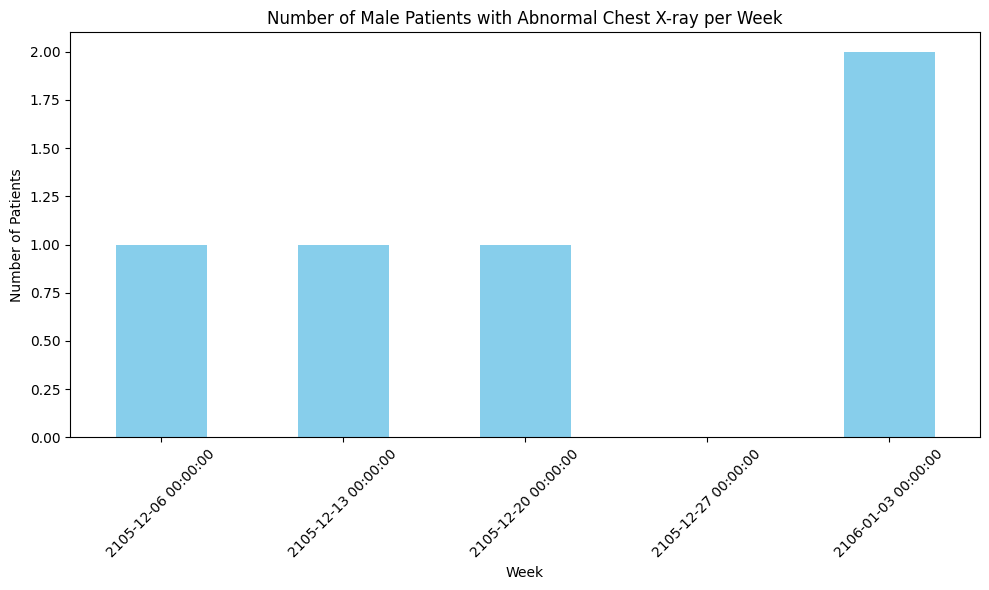

content=[{'question': 'Plot number of male patient in each week that has chex-xray in last month and their chest-xray showed abnormality.', 'database_schema': '\nCREATE TABLE "PATIENTS" (\n\trow_id INTEGER, \n\tsubject_id INTEGER, \n\tgender TEXT, \n\tdob TEXT, \n\tdod TEXT\n)\n\n\nCREATE TABLE "TB_CXR" (\n\trow_id INTEGER, \n\tsubject_id INTEGER, \n\thadm_id REAL, \n\tstudy_id INTEGER, \n\timage_id TEXT, \n\tviewposition TEXT, \n\tstudydatetime TEXT, \n\timage_path TEXT, \n\treport_path TEXT\n)'}] id='1f62682b-40bb-4d09-a196-979899f1c6ed'
---
content="{'status': 'success', 'data': [{'subject_id': 10501557, 'study_id': 50494231, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10501557/s50494231/dc8e362f-c7eed9e4-23b6a482-f5914468-cfee1143.jpg'}, {'subject_id': 10501557, 'study_id': 52176984, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10501557/s52176984/b011d8cc-dc7132b2-88dbf1ce-25edfe98-e7f91d64.jpg'}, {'subject_id': 10737408, 'study_id': 528

In [13]:
for step in chain.invoke(inputs):
    print(step)
    print("---")

context-first: {'status': 'success', 'data': [{'subject_id': 10501557, 'study_id': 50494231, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10501557/s50494231/dc8e362f-c7eed9e4-23b6a482-f5914468-cfee1143.jpg'}, {'subject_id': 10501557, 'study_id': 52176984, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10501557/s52176984/b011d8cc-dc7132b2-88dbf1ce-25edfe98-e7f91d64.jpg'}, {'subject_id': 10737408, 'study_id': 52883453, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10737408/s52883453/b67361c3-3f5ae62e-460f6431-325adf4d-0d2b1e14.jpg'}, {'subject_id': 10737408, 'study_id': 57292936, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10737408/s57292936/42129ce4-60759151-2961e757-ed99e1bc-5fbd5220.jpg'}, {'subject_id': 11053589, 'study_id': 56374336, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p11/p11053589/s56374336/3ff536d0-58474ed7-f99f6fc1-54ca116d-4838ad24.jpg'}, {'subject_id': 12215941, 'stu

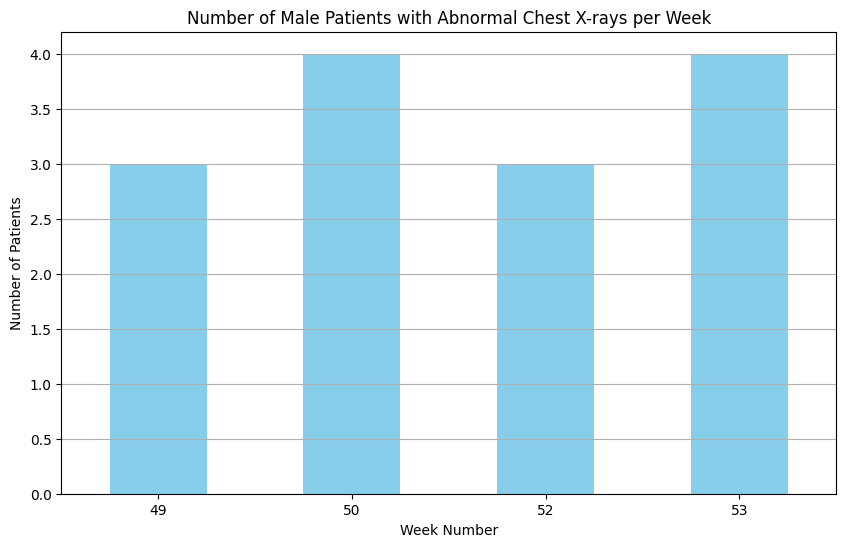

content=[{'question': 'Plot number of male patient in each week that has chex-xray in last month and their chest-xray showed abnormality.', 'database_schema': '\nCREATE TABLE "PATIENTS" (\n\trow_id INTEGER, \n\tsubject_id INTEGER, \n\tgender TEXT, \n\tdob TEXT, \n\tdod TEXT\n)\n\n\nCREATE TABLE "TB_CXR" (\n\trow_id INTEGER, \n\tsubject_id INTEGER, \n\thadm_id REAL, \n\tstudy_id INTEGER, \n\timage_id TEXT, \n\tviewposition TEXT, \n\tstudydatetime TEXT, \n\timage_path TEXT, \n\treport_path TEXT\n)'}] id='736926e6-1dec-4fa6-b0f9-355bf10ec3ea'
---
content="{'status': 'success', 'data': [{'subject_id': 10501557, 'study_id': 50494231, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10501557/s50494231/dc8e362f-c7eed9e4-23b6a482-f5914468-cfee1143.jpg'}, {'subject_id': 10501557, 'study_id': 52176984, 'image_path': '/home/ubuntu/workspace/XMODE-LLMCompiler/files/p10/p10501557/s52176984/b011d8cc-dc7132b2-88dbf1ce-25edfe98-e7f91d64.jpg'}, {'subject_id': 10737408, 'study_id': 528

In [13]:

for step in chain.invoke(inputs):
    print(step)
    print("---")